In [107]:
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import numpy as np
import utility as ut
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
import seaborn as sns
import oneshot as sm
import surrogate as sr 
import torch
import hr_full as hrf
from torch import nn
import eulerN as arch1
import eulerSnake as arch2
import eulerSN as arch3

Time taken by sample is 0.0303 seconds
Time taken by sample is 0.0401 seconds
Time taken by sample is 0.0366 seconds
Time taken by sample is 0.0402 seconds
Time taken by sample is 0.0405 seconds
Time taken by sample is 0.0429 seconds
Time taken by sample is 0.0390 seconds


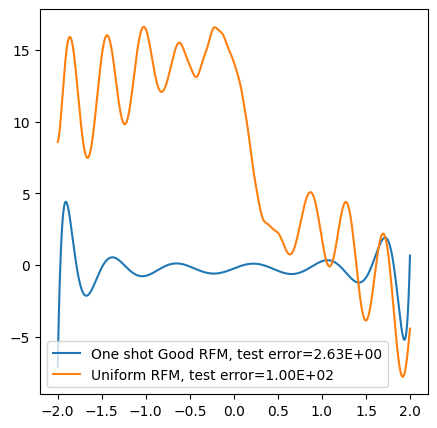

In [129]:
description = "This experiment checks deep vs shallow RFM for approximation task. The function used here is tasmania(x) = 0.03 - (1.4 - 2.5*(x+0.5)) * np.sin(15*(x+0.5))."
experimentFolder = '../data/deep-vs-shallow-tasmania'
ut.makeDir(experimentFolder)

tasmania = lambda x: 0.03 - (1.4 - 2.5*(x+0.5)) * np.sin(15*(x+0.5))
a, b = -2.0, 2.0
x = np.linspace(a, b, num=500000)
x_ = np.random.choice(x, size=50000, replace=False)


test_x = np.random.uniform(a, b, size=(1, 1000))
test_y = tasmania(test_x)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# ax.scatter(x, tasmania(x), s=1, label="data")

L0, L1, D, D_r, beta, N = 0.25, 5., 1, 1500, 5e-10, 2000
Uo = x_.reshape(-1, 1).T
sampler = sm.MatrixSampler(L0, L1, Uo)
B = 2


def normalize(X, Y):
    return (X - np.mean(Uo)) / np.std(Uo) , (Y - np.mean(tasmania(Uo))) / np.std(tasmania(Uo)) 

def revert(X, Y):
    return (X * np.std(Uo) + np.mean(Uo))  , (Y * np.std(tasmania(Uo)) + np.mean(tasmania(Uo))) 

deepRFM1 = arch1.DeepRF(D_r, B, L0, L1, Uo, beta, name=f"EulerN of depth {B}")
deepRFM1.init_xy(*normalize(Uo, tasmania(Uo)))

deepRFM2 = arch2.DeepRF(D_r, B, 100.0, L0, L1, Uo, beta, name=f"EulerSnake of depth {B}")
deepRFM2.init_xy(*normalize(Uo, tasmania(Uo)))


goodWb = sampler.sample_([D_r, 0, 0])
goodRFM = sr.SurrogateModel_LR(D=D, D_r=D_r, W_in_fn=goodWb[:, :-1], b_in_fn=goodWb[:, -1], name="One shot Good RFM")
goodRFM.compute_W_xy(*(Uo, tasmania(Uo)), beta)
goodRFM.validation_error(test_x, test_y)

uniformWb = np.random.uniform([-5., -2.], [5., 2.], size=(D_r, D+1))
uniformRFM = sr.SurrogateModel_LR(D=D, D_r=D_r, W_in_fn=uniformWb[:, :-1], b_in_fn=uniformWb[:, -1], name="Uniform RFM")
uniformRFM.compute_W_xy(Uo, tasmania(Uo), beta)
uniformRFM.validation_error(test_x, test_y)

x = np.linspace(a, b, num=1000)
Ux = x.reshape(-1, 1).T
y = tasmania(x)

def draw(rfm, norm=False):
    if norm:
        Ux_, _ = normalize(Ux, tasmania(Ux))
        y_hat_ = rfm.forecast_m(Ux_).flatten()
        _, y_hat = revert(Ux_, y_hat_)
    else:
        y_hat = rfm.forecast_m(Ux).flatten()
    error = np.sum((y-y_hat)**2) / len(y)
    ax.plot(x, y_hat, label=f"{rfm.name}, test error={error:.2E}")

# draw(deepRFM1, True)
# draw(deepRFM2, True)
draw(goodRFM, False)
draw(uniformRFM)

# ax.scatter(Uo, tasmania(Uo), marker="x")
ax.legend()

expLogger = ut.ExperimentLogger(experimentFolder, description)
expLogger.add(goodRFM, uniformRFM, deepRFM1, deepRFM2)

plt.savefig(f"{experimentFolder}/fit_beta_{beta}.png")

In [ ]:
np.mean(tasmania(Uo), axis=1)

In [5]:
Uo

array([[ 0.71909691, -0.51477648,  0.02062706, ..., -0.10793579,
         0.0650315 , -0.39371437]])

In [125]:
np.tanh(5.)

0.9999092042625951